## Escolher uma das colunas dos dados utilizados no projeto 1 para predição (classificação ou regressão)

In [1]:
# !pip install mlflow
# !pip install --upgrade setuptools
# !pip install scikit-optimize

In [71]:
import pandas as pd
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [3]:
path_raw = os.getenv('PATH_RAW')
# df_raw = pd.read_csv('scraped_data.csv', sep=',')
df_raw = pd.read_csv('../scraped_data.csv', sep=',', nrows=1000)

In [4]:
df_raw.head(1)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,...,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,...,False,False,False,True,False,False,3,20,0,3


In [5]:
df_0 = df_raw.copy()

In [6]:
df_0 = df_0.drop(columns=['find_anuncio','find_descri']) 

df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]
df_0 = df_0.drop(columns=['find_endereco'])

In [7]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')

In [8]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [9]:
df_0 = df_0.drop_duplicates()

In [10]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

Imputing row 1/918 with 0 missing, elapsed time: 0.137
Imputing row 101/918 with 0 missing, elapsed time: 0.139
Imputing row 201/918 with 0 missing, elapsed time: 0.139
Imputing row 301/918 with 0 missing, elapsed time: 0.139
Imputing row 401/918 with 0 missing, elapsed time: 0.140
Imputing row 501/918 with 0 missing, elapsed time: 0.140
Imputing row 601/918 with 0 missing, elapsed time: 0.140
Imputing row 701/918 with 0 missing, elapsed time: 0.140
Imputing row 801/918 with 0 missing, elapsed time: 0.141
Imputing row 901/918 with 0 missing, elapsed time: 0.141


In [11]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

In [12]:
df_0.head(1)

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,...,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP
0,1100.0,180.0,365.0,105.0,380000.0,26.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,305.0


In [13]:
df_1 = df_0.copy()

vamos escolher a coluna de preço para fazer regressão

In [14]:
y = df_1['find_price']

In [15]:
X = df_1.drop(columns=['find_price'])

## Separar os dados em treinamento, validação e teste

temos que revisar as proporções que o professor que que use, eu lembro dele ter dito que queria, k folds

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Selecionar 4 algoritmos de acordo com a tarefa escolhida no passo 1

In [161]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor(hidden_layer_sizes=(1024, 512, 124, 124, 64, 64, 64))

In [18]:
from sklearn.ensemble  import RandomForestRegressor
rfr = RandomForestRegressor()

In [19]:
from sklearn.ensemble  import GradientBoostingRegressor
gbr = GradientBoostingRegressor()

In [20]:
from sklearn.neighbors   import KNeighborsRegressor
knnr = KNeighborsRegressor()

## Adicionar MLFlow no treinamento dos modelos para rastreamento

In [21]:
import mlflow
import mlflow.sklearn 

In [22]:
mlflow.set_experiment("nome_do_seu_experimento")

<Experiment: artifact_location='file:///c:/Users/davim/OneDrive/Desktop/playground/scraping/notebook_analysis/mlruns/964034627453830662', creation_time=1720291533006, experiment_id='964034627453830662', last_update_time=1720291533006, lifecycle_stage='active', name='nome_do_seu_experimento', tags={}>

## Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação

In [61]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

vamos usar kfolds

In [74]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Selecionar poucos hiper-parâmetros por algoritmo (max. 3)

#### RandomForestRegressor

In [63]:
search_space = {
    'criterion': ("squared_error", "absolute_error", "friedman_mse", "poisson"), 
    'max_features':("sqrt", "log2") 
}

In [64]:
opt = BayesSearchCV(
    estimator=rfr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)


In [65]:
opt.fit(X_val, y_val)

c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 'log2'] before, using random point ['poisson', 'log2']
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['friedman_mse', 'log2'] before, using random point ['squared_error', 'log2']
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['absolute_error', 'sqrt'] before, using random point ['friedman_mse', 'log2']
  warnings.warn(


BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestRegressor(), n_iter=15, n_jobs=-1,
              random_state=42,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'criterion': ('squared_error', 'absolute_error',
                                           'friedman_mse', 'poisson'),
                             'max_features': ('sqrt', 'log2')})

In [66]:
best_model_rfr = RandomForestRegressor(**opt.best_params_)
# Get the best parameters and score
print("Best parameters found: ", opt.best_params_)

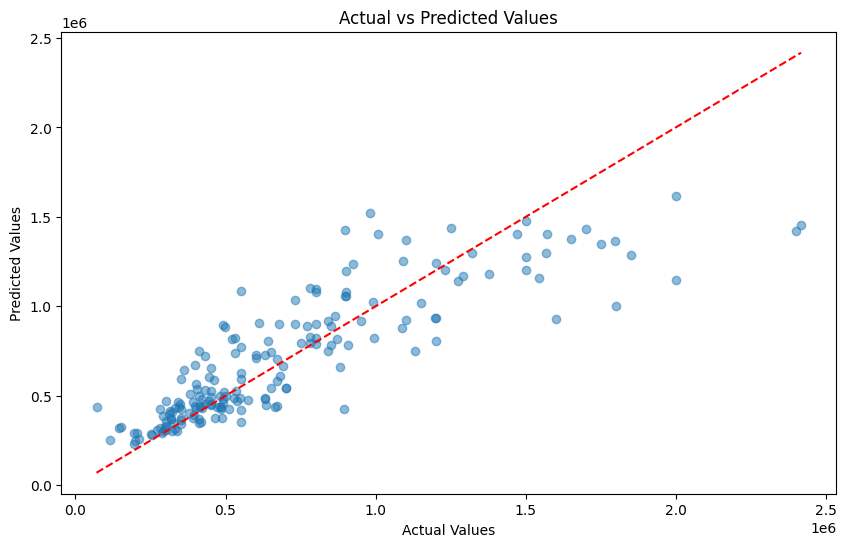

Root Mean Squared Error: 233578.15307676842


In [73]:
# Start an MLflow run
with mlflow.start_run(run_name="RandomForestRegressor"):
    # Log parameters
    mlflow.log_params(opt.best_params_)

    best_model_rfr.fit(X_train,y_train)
    # Make predictions on the test data
    y_pred = best_model_rfr.predict(X_test)
    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)
    # Log the model
    mlflow.sklearn.log_model(best_model_rfr, 'model')

    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')


#### mlp

In [162]:
from sklearn.preprocessing import StandardScaler

In [163]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [164]:
search_space = {
    'learning_rate':["constant", "invscaling", "adaptive"],
    'learning_rate_init':[0.01, 0.001, 0.0001]
}

In [165]:
opt = BayesSearchCV(
    estimator=mlpr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

In [166]:
opt.fit(X_val_scaled, y_val)

c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['constant', 0.0001] before, using random point ['invscaling', 0.01]
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['constant', 0.0001] before, using random point ['adaptive', 0.001]
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['adaptive', 0.0001] before, using random point ['constant', 0.0001]
  warnings.warn(
c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['constant', 0.0001] before, using random point ['invscaling', 0.001]
  warnings.wa

BayesSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=MLPRegressor(hidden_layer_sizes=(1024, 512, 124, 124,
                                                         64, 64, 64)),
              n_iter=15, n_jobs=-1, random_state=42,
              scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
              search_spaces={'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.01, 0.001, 0.0001]})

In [167]:
best_model_mlpr = MLPRegressor(**opt.best_params_)
print("Best parameters found: ", opt.best_params_)

Best parameters found:  OrderedDict({'learning_rate': 'constant', 'learning_rate_init': 0.0001})


c:\Users\davim\OneDrive\Desktop\playground\scraping\myenv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


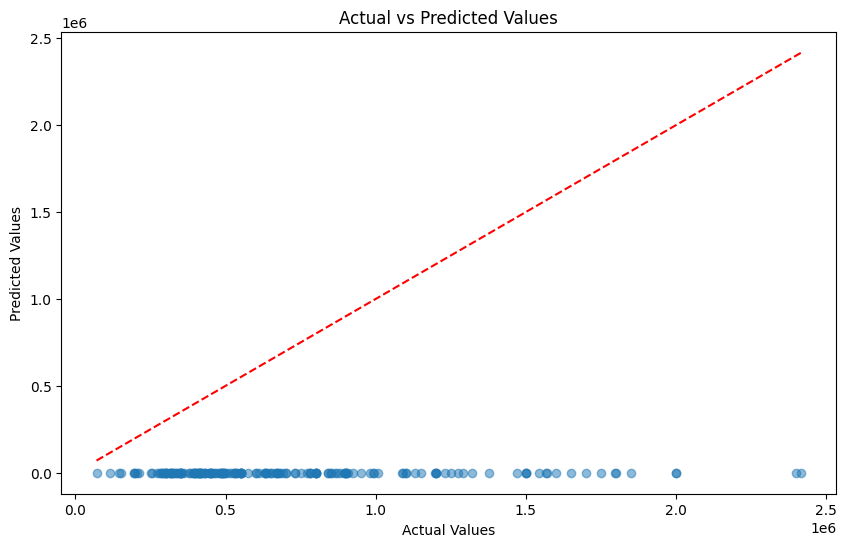

Root Mean Squared Error: 834673.4613433278


In [170]:
# Start an MLflow run
with mlflow.start_run(run_name="MLPRegressor"):
    # Log parameters
    mlflow.log_params(opt.best_params_)

    best_model_mlpr.fit(X_train_scaled,y_train)
    # Make predictions on the test data
    y_pred = best_model_mlpr.predict(X_test_scaled)
    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)
    # Log the model
    mlflow.sklearn.log_model(best_model_mlpr, 'model')

    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')

In [171]:
y_pred_test = best_model_mlpr.predict(X_test_scaled)
y_pred_train = best_model_mlpr.predict(X_train_scaled)
# Calculate MSE for training set
train_mse = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Calculate MSE for test set
test_mse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_mse}")
print(f"Test  RMSE: {test_mse}")

Train RMSE: 791599.7707878898
Test  RMSE: 834673.4613433278


Selecionar o modelo (algoritmo+valores de hiper-parâmetros) com
melhor resultado na métrica de avaliação

Executar o melhor modelo de cada algoritmo no conjunto de teste e
selecionar o melhor modelo geral na métrica de avaliação

## Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico

Bônus: Utilizar auto-sklearn, clustering para entendimento dos
dados